<a href="https://colab.research.google.com/github/ovieimara/machine_learning/blob/main/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.5.0


In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  ds = iter(dataset.flat_map(lambda x: x))
  print (next(ds))
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

tf.Tensor(52.48357, shape=(), dtype=float32)


In [8]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))


tf.Tensor(52.48357, shape=(), dtype=float32)
<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Layer weights [array([[-0.05275898],
       [-0.00313857],
       [ 0.03801133],
       [ 0.04832603],
       [-0.0146458 ],
       [-0.03970325],
       [-0.02868145],
       [ 0.07607033],
       [-0.02149639],
       [ 0.02841447],
       [-0.03661492],
       [ 0.0584581 ],
       [-0.08374722],
       [ 0.02716343],
       [ 0.03501908],
       [ 0.05742212],
       [ 0.03540488],
       [ 0.10141644],
       [ 0.3420435 ],
       [ 0.43295118]], dtype=float32), array([0.01675839], dtype=float32)]


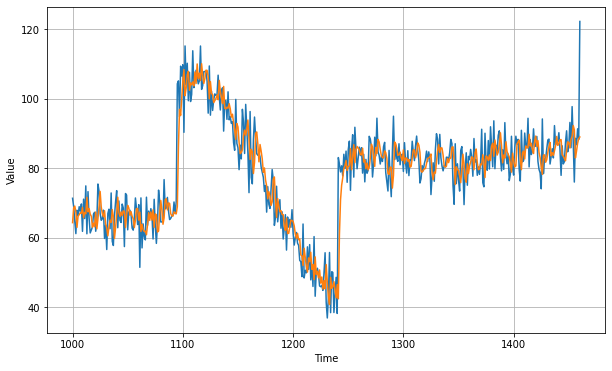

In [17]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [15]:
print(np.array(forecast)[:, 0, 0])

[ 64.32405   68.592094  69.09008   67.43275   62.95772   66.21764
  66.62117   67.15863   67.00809   68.7256    65.759605  67.28341
  66.85154   71.63181   67.416855  68.3554    66.78524   66.16671
  62.96105   64.177376  63.152946  67.38006   62.540108  65.35998
  68.87899   73.32338   68.829216  66.91852   66.01411   67.7536
  63.949467  62.73167   60.509785  63.09362   65.02343   64.398506
  68.079384  65.99915   59.76473   62.8395    66.632256  71.644
  67.18992   66.13285   67.40376   66.340355  67.70976   67.57353
  62.923527  66.4866    69.28868   68.56898   66.46192   67.513535
  66.159004  65.42637   62.904213  65.10649   68.35259   68.39659
  65.03906   67.33415   61.785255  63.820118  62.295322  61.78836
  61.87228   60.835518  63.761173  67.189354  64.96042   67.40341
  65.052444  68.01092   62.965843  66.84558   66.5898    61.605595
  61.906536  67.10463   70.7062    67.95884   63.862064  65.693474
  70.920074  71.22898   68.00913   70.012375  69.88318   66.90679
  66.2808

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.9880233